# KE5006 Applied Research

### Identifying enhancers and their strength with deep neural networks

# Preliminary Layer 1 Model with Physiochemical Property Features

## Summary of Findings
* Base model of 1x16 Conv1D, 2x8 GRU Bi-directional, 1x8 Dense
	* Overfits with a maximum validation accuracy of xx.xx% at epoch xxx on 2:1 split.

## Load libraries

In [1]:
# Set the working directory (which contains the directories source, data, etc.)
import os
os.chdir(os.path.join(os.path.sep, 'home', 'tkokkeng', 'Documents', 'KE5006-AppliedResearch', 'enhancer'))
os.getcwd()

'/home/tkokkeng/Documents/KE5006-AppliedResearch/enhancer'

In [2]:
# Check if the directory containing the source files are in the path.
import sys
if os.path.join(os.getcwd(), 'source') not in sys.path:
    sys.path.append(os.path.join(os.getcwd(), 'source'))
sys.path

['/home/tkokkeng/python/python367/tsfvenv/lib/python36.zip',
 '/home/tkokkeng/python/python367/tsfvenv/lib/python3.6',
 '/home/tkokkeng/python/python367/tsfvenv/lib/python3.6/lib-dynload',
 '/usr/lib/python3.6',
 '',
 '/home/tkokkeng/python/python367/tsfvenv/lib/python3.6/site-packages',
 '/home/tkokkeng/.local/lib/python3.6/site-packages',
 '/usr/local/lib/python3.6/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/home/tkokkeng/python/python367/tsfvenv/lib/python3.6/site-packages/IPython/extensions',
 '/home/tkokkeng/.ipython',
 '/home/tkokkeng/Documents/KE5006-AppliedResearch/enhancer/source']

In [35]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
import pickle

import myUtilities as mu

from sklearn.metrics import classification_report, confusion_matrix, matthews_corrcoef, make_scorer, recall_score, roc_auc_score, roc_curve 
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.preprocessing import MinMaxScaler

from keras.preprocessing.text import Tokenizer
from keras.models import Sequential, load_model
from keras import layers
from keras.optimizers import RMSprop
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

## Load data

In [4]:
enhancer_df = pd.read_csv(os.path.join('data', 'enhancer.csv'))
enhancer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1484 entries, 0 to 1483
Data columns (total 2 columns):
id          1484 non-null object
sequence    1484 non-null object
dtypes: object(2)
memory usage: 23.3+ KB


In [5]:
enhancer_df['enhancer'] = np.ones((len(enhancer_df),))

In [6]:
enhancer_df.head()

,id,sequence,enhancer
0,CHRX_48897056_48897256,CACAATGTAGAAGCAGAGACACAGGAACCAGGCTTGGTGATGGCTC...,1.0
1,CHR12_6444339_6444539,GCCCTCACATTCCCTGGCCCATCCCCTCCACCTCAAAATTTACAAA...,1.0
2,CHR12_6444939_6445139,GAGCAGGAGGCCAGTCACCCTGAGTCAGCCACGGGGAGACGCTGCA...,1.0
3,CHR12_6445139_6445339,CCTCTGCTGAGAACAGGACTGGGGCTTCCAGGGCAACAGGAAGGGT...,1.0
4,CHR12_6445339_6445539,ACAGCCTTAAAGGGAGCTTTTCAGGGACCTCTGGCCAGTGGGGGAT...,1.0


In [7]:
non_enhancer_df = pd.read_csv(os.path.join('data', 'non_enhancer.csv'))
non_enhancer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1484 entries, 0 to 1483
Data columns (total 2 columns):
id          1484 non-null object
sequence    1484 non-null object
dtypes: object(2)
memory usage: 23.3+ KB


In [8]:
non_enhancer_df['enhancer'] = np.zeros((len(non_enhancer_df),))

In [9]:
non_enhancer_df.head()

,id,sequence,enhancer
0,CHRX_2970600_2970800,CAGTCACATCTGTAATCACAATACGTTGGGAGGCTGAGGCAGGAGG...,0.0
1,CHRX_6179400_6179600,ACTTTGAAGAAGTCAGTCATCAAGATGAGAGACCCAACTGTCAAGC...,0.0
2,CHRX_11003079_11003279,TCGGCCTCCCAAAGTGCTGGGATTATAGGCATGAGCTACTGCACCC...,0.0
3,CHRX_22042679_22042879,TGGGAGCTGTATCAATCATGTTTTTTATTTTCTATATTTTATGATG...,0.0
4,CHRX_23280479_23280679,TACAGCAAATAGCCTTGGCAGATACAGTGTTTCCCTCCAGAGCAAA...,0.0


## Combine the data frames to form a single dataset

In [10]:
all_data_df = pd.concat([enhancer_df, non_enhancer_df])
all_data_df.reset_index(drop=True, inplace=True)
all_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2968 entries, 0 to 2967
Data columns (total 3 columns):
id          2968 non-null object
sequence    2968 non-null object
enhancer    2968 non-null float64
dtypes: float64(1), object(2)
memory usage: 69.6+ KB


In [11]:
all_data_df.head()

,id,sequence,enhancer
0,CHRX_48897056_48897256,CACAATGTAGAAGCAGAGACACAGGAACCAGGCTTGGTGATGGCTC...,1.0
1,CHR12_6444339_6444539,GCCCTCACATTCCCTGGCCCATCCCCTCCACCTCAAAATTTACAAA...,1.0
2,CHR12_6444939_6445139,GAGCAGGAGGCCAGTCACCCTGAGTCAGCCACGGGGAGACGCTGCA...,1.0
3,CHR12_6445139_6445339,CCTCTGCTGAGAACAGGACTGGGGCTTCCAGGGCAACAGGAAGGGT...,1.0
4,CHR12_6445339_6445539,ACAGCCTTAAAGGGAGCTTTTCAGGGACCTCTGGCCAGTGGGGGAT...,1.0


All the sequences are of length 200 characters.

In [12]:
all_data_df['sequence'].map(lambda x: len(x)).value_counts()

200    2968
Name: sequence, dtype: int64

## Load the physiochemical property data

In [13]:
pcp_df = pd.read_csv(os.path.join('data', 'S2.csv'), index_col=0)
pcp_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16 entries, AA to TT
Data columns (total 6 columns):
Rise     16 non-null float64
Roll     16 non-null float64
Shift    16 non-null float64
Slide    16 non-null float64
Tilt     16 non-null float64
Twist    16 non-null float64
dtypes: float64(6)
memory usage: 896.0+ bytes


In [14]:
scaler = MinMaxScaler()
pcp_df.loc[:, :] = scaler.fit_transform(pcp_df.values)
pcp_df

,Rise,Roll,Shift,Slide,Tilt,Twist
AA,0.430303,0.403042,1.000000,0.545455,0.4,0.833333
AC,0.818182,0.695817,0.618557,1.000000,0.7,0.833333
AG,0.257576,0.315589,0.762887,0.772727,0.3,0.791667
AT,0.860606,1.000000,0.319588,0.863636,0.6,0.750000
CA,0.045455,0.220532,0.360825,0.090909,0.1,0.291667
CC,0.548485,0.171103,0.731959,0.545455,0.3,1.000000
CG,0.000000,0.304183,0.371134,0.000000,0.0,0.333333
CT,0.257576,0.315589,0.762887,0.772727,0.3,0.791667
GA,0.706061,0.277567,0.618557,0.500000,0.4,0.833333
GC,1.000000,0.536122,0.494845,0.500000,1.0,0.750000


## Prepare the sequence data for modelling

Create a transformation pipleline to prepare the training dataset for RNN.

In [15]:
# This class selects the desired attributes and drops the rest.
class DataFrameSelector(BaseEstimator, TransformerMixin):

    def __init__(self, attribute_names):
        self.attribute_names = attribute_names

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.attribute_names]

In [16]:
# This class converts a nucleotide base (A, C, G, T) to one-hot-encoding.
class one_hot_encoder(BaseEstimator, TransformerMixin):

    def __init__(self):
        self.tokenizer = Tokenizer(num_words=4, lower=False, char_level=True)

    def fit(self, X, y=None):
        # Note that X is a data frame.
        # Fit the tokenizer on the 1st sequence in the dataset.
        self.tokenizer.fit_on_texts(X.iloc[0, 0])
        self.len_sequence = len(X.iloc[0, 0])
        return self

    def transform(self, X):
        # Note that X is a data frame.
        one_hot_X = X.iloc[:, 0].map(lambda x: self.tokenizer.texts_to_matrix(x, mode='binary')).values
        one_hot_X = np.concatenate(one_hot_X)
        one_hot_X = np.reshape(one_hot_X, (-1, self.len_sequence, 4))
        return one_hot_X

In [17]:
# This class converts a sequence of nucleotide bases (A, C, G, T) to a sequence of dinucleotides and then to a sequence of pysiochemical properties of each dinucleotide.
class pcp_encoder(BaseEstimator, TransformerMixin):

    def __init__(self, pcp_df):
        self.pcp_df = pcp_df

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Note that X is a data frame.
        dinuc_seq = X.iloc[:, 0].map(lambda x: [ x[i:i+2] for i in range(len(x) - 1) ])
        pcp_seq = dinuc_seq.map(lambda x: [ pcp_df[j][i] for i in x for j in pcp_df.columns.tolist() ])
        # Pad with -1 for last element of sequence; it does not have an associated di-nucleotide
        pcp_seq = pcp_seq.map(lambda x: np.array(x + [-1. for i in range(len(pcp_df.columns))]).reshape((len(X.iloc[0, 0]), len(pcp_df.columns)))).values
        # pandas values returns a 1-D array of objects; use numpy stack to reshape it to a multi-dimensional array
        return np.stack(pcp_seq)

In [18]:
# This class shapes a numpy array.
class Array_Shaper(BaseEstimator, TransformerMixin):
    
    def __init__(self, shape):
        self.shape = shape
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.reshape(self.shape)

In [19]:
attrbs = ['sequence']
num_bases = 4  # number of nucleotide bases
num_pcp = 6  # number of di-nucleotide physiochemical properties
len_seq = len(all_data_df['sequence'][0])
one_hot_pipeline = Pipeline([
    ('selector', DataFrameSelector(attrbs)),
    ('one_hot_encoder', one_hot_encoder()),
    ('array_shaper2D', Array_Shaper((-1, num_bases)))
])
pcp_pipeline = Pipeline([
    ('selector', DataFrameSelector(attrbs)),
    ('pcp_encoder', pcp_encoder(pcp_df)),
    ('array_shaper2D', Array_Shaper((-1, num_pcp)))
])
union_pipeline = FeatureUnion(transformer_list=[
    ("one_hot_pipeline", one_hot_pipeline),
    ("pcp_pipeline", pcp_pipeline)
])
my_pipeline = Pipeline([
    ('feature_combiner', union_pipeline),
    ('array_shaper3D', Array_Shaper((-1, len_seq, num_bases + num_pcp)))
])

In [20]:
X = my_pipeline.fit_transform(all_data_df)
X.shape

(2968, 200, 10)

Check the 1st sequence is correctly encoded.

In [21]:
X[0, :10, :]

array([[0.        , 0.        , 0.        , 0.        , 0.04545455,
        0.22053232, 0.36082474, 0.09090909, 0.1       , 0.29166667],
       [0.        , 0.        , 0.        , 1.        , 0.81818182,
        0.69581749, 0.6185567 , 1.        , 0.7       , 0.83333333],
       [0.        , 0.        , 0.        , 0.        , 0.04545455,
        0.22053232, 0.36082474, 0.09090909, 0.1       , 0.29166667],
       [0.        , 0.        , 0.        , 1.        , 0.43030303,
        0.40304183, 1.        , 0.54545455, 0.4       , 0.83333333],
       [0.        , 0.        , 0.        , 1.        , 0.86060606,
        1.        , 0.31958763, 0.86363636, 0.6       , 0.75      ],
       [0.        , 0.        , 1.        , 0.        , 0.04545455,
        0.22053232, 0.36082474, 0.09090909, 0.1       , 0.29166667],
       [0.        , 1.        , 0.        , 0.        , 0.81818182,
        0.69581749, 0.6185567 , 1.        , 0.7       , 0.83333333],
       [0.        , 0.        , 1.       

In [22]:
X[0, -10:, :]

array([[ 0.        ,  0.        ,  1.        ,  0.        ,  0.43030303,
         0.40304183,  1.        ,  0.54545455,  0.4       ,  0.83333333],
       [ 0.        ,  0.        ,  1.        ,  0.        ,  0.04545455,
         0.22053232,  0.36082474,  0.09090909,  0.1       ,  0.29166667],
       [ 0.        ,  1.        ,  0.        ,  0.        ,  0.81818182,
         0.69581749,  0.6185567 ,  1.        ,  0.7       ,  0.83333333],
       [ 0.        ,  0.        ,  1.        ,  0.        ,  0.70606061,
         0.27756654,  0.6185567 ,  0.5       ,  0.4       ,  0.83333333],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.54848485,
         0.17110266,  0.73195876,  0.54545455,  0.3       ,  1.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.25757576,
         0.31558935,  0.7628866 ,  0.77272727,  0.3       ,  0.79166667],
       [ 0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.13636364

In [23]:
y = all_data_df['enhancer'].values
y.shape

(2968,)

In [24]:
y[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

## Split the dataset into train / validation sets

For the initial base model, we will use a simple train / validation split. 5-fold cross-validation will be used during model fine-tuning to obtain the final model.

In [25]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=123)

In [26]:
X_train.shape

(1988, 200, 10)

In [27]:
X_train[0][:10]

array([[0.        , 0.        , 0.        , 0.        , 0.25757576,
        0.31558935, 0.7628866 , 0.77272727, 0.3       , 0.79166667],
       [0.        , 0.        , 1.        , 0.        , 0.        ,
        0.        , 0.        , 0.13636364, 0.        , 0.        ],
       [0.        , 0.        , 0.        , 1.        , 0.81818182,
        0.69581749, 0.6185567 , 1.        , 0.7       , 0.83333333],
       [0.        , 0.        , 0.        , 0.        , 0.54848485,
        0.17110266, 0.73195876, 0.54545455, 0.3       , 1.        ],
       [0.        , 0.        , 0.        , 0.        , 0.04545455,
        0.22053232, 0.36082474, 0.09090909, 0.1       , 0.29166667],
       [0.        , 0.        , 0.        , 1.        , 0.43030303,
        0.40304183, 1.        , 0.54545455, 0.4       , 0.83333333],
       [0.        , 0.        , 0.        , 1.        , 0.86060606,
        1.        , 0.31958763, 0.86363636, 0.6       , 0.75      ],
       [0.        , 0.        , 1.       

In [28]:
y_train.shape

(1988,)

In [29]:
y_train[0]

1.0

## Train a base RNN model

In this training phase, the aim is to find a base model with statistical power which overfits. Interatively, this base model will be scaled up first to overfit, to be followed by regularization, to improve the validation accuracy.

In the next phase, cross-validation will be applied to obtain better estimates of validation accuracy. Grid-search can be applied to fine-tune the parameters, hyper-parameters to further improve the validation accuracy.

### 1x16 Conv1D, 2x8 GRU Bi-directional, 1x8 Dense

In [30]:
from numpy.random import seed
seed(123)
from tensorflow import set_random_seed
set_random_seed(456)

In [31]:
model = Sequential()
model.add(layers.Conv1D(16, 9, activation='relu', input_shape=(200, X_train.shape[-1])))
model.add(layers.MaxPooling1D(2))
model.add(layers.Bidirectional(layers.CuDNNGRU(8, return_sequences=True)))
model.add(layers.Bidirectional(layers.CuDNNGRU(8)))
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer=RMSprop(), loss='binary_crossentropy', metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 192, 16)           1456      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 96, 16)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 96, 16)            1248      
_________________________________________________________________
bidirectional_2 (Bidirection (None, 16)                1248      
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 4,097
Trainable params: 4,097
Non-trainable params: 0
_________________________________________________________________


In [32]:
callbacks_list = [
    # ModelCheckpoint(
    #     filepath='base1mrb-4x128gru-2x32dense.best.h5',
    #     monitor='val_loss',
    #     save_best_only=True
    # ),
    TensorBoard(
        log_dir='tsb_log'
    )
]

In [34]:
train_to_epoch = 1000
start_epoch = 3
t1 = datetime.datetime.now()
print('Training start time = %s' %  t1)
history = model.fit(X_train, y_train,
                    batch_size=128,  epochs=train_to_epoch, verbose=0,
                    callbacks=callbacks_list, initial_epoch=start_epoch,
                    validation_data=(X_val, y_val), shuffle=True)
print('\nTraining Duration = %s' % (datetime.datetime.now()-t1))

Training start time = 2019-03-18 23:13:42.460464

Training Duration = 0:04:44.648514


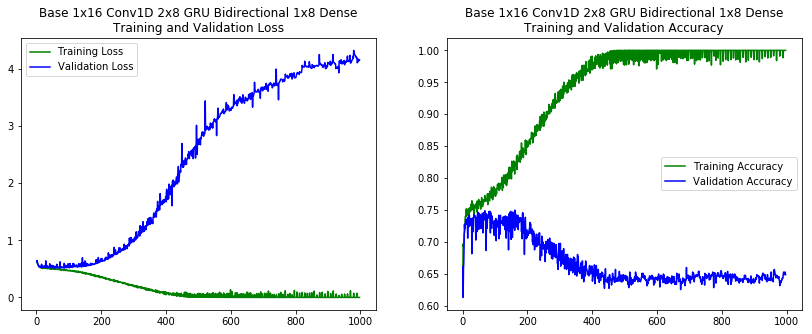

In [35]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['acc']
val_acc = history.history['val_acc']
epochs = range(1, len(train_loss) + 1)
plt.figure(figsize=(14, 5))
plt.subplot(121)
plt.plot(epochs, train_loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Base 1x16 Conv1D 2x8 GRU Bidirectional 1x8 Dense\nTraining and Validation Loss')
plt.legend()
plt.subplot(122)
plt.plot(epochs, train_acc, 'g', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Base 1x16 Conv1D 2x8 GRU Bidirectional 1x8 Dense\nTraining and Validation Accuracy')
plt.legend()
plt.show()

In [36]:
print('validation loss = {:6.2f} at epoch = {:4d}'.format(min(val_loss), val_loss.index(min(val_loss))))
print('validation accuracy = {:6.2f}% at epoch = {:4d}'.format(max(val_acc) * 100, val_acc.index(max(val_acc))))

validation loss =   0.52 at epoch =   86
validation accuracy =  75.00% at epoch =  161


### 1x16 Conv1D, 1x8 GRU Bi-directional, 1x8 Dense

In [37]:
from numpy.random import seed
seed(123)
from tensorflow import set_random_seed
set_random_seed(456)

In [38]:
model = Sequential()
model.add(layers.Conv1D(16, 9, activation='relu', input_shape=(200, X_train.shape[-1])))
model.add(layers.MaxPooling1D(2))
model.add(layers.Bidirectional(layers.CuDNNGRU(8)))
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer=RMSprop(), loss='binary_crossentropy', metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 192, 16)           1456      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 96, 16)            0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 16)                1248      
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 9         
Total params: 2,849
Trainable params: 2,849
Non-trainable params: 0
_________________________________________________________________


In [39]:
callbacks_list = [
    # ModelCheckpoint(
    #     filepath='base1mrb-4x128gru-2x32dense.best.h5',
    #     monitor='val_loss',
    #     save_best_only=True
    # ),
    TensorBoard(
        log_dir='tsb_log'
    )
]

In [41]:
train_to_epoch = 1000
start_epoch = 0
t1 = datetime.datetime.now()
print('Training start time = %s' %  t1)
history = model.fit(X_train, y_train,
                    batch_size=128,  epochs=train_to_epoch, verbose=0,
                    callbacks=callbacks_list, initial_epoch=start_epoch,
                    validation_data=(X_val, y_val), shuffle=True)
print('\nTraining Duration = %s' % (datetime.datetime.now()-t1))

Training start time = 2019-03-18 23:29:22.517629

Training Duration = 0:02:46.807673


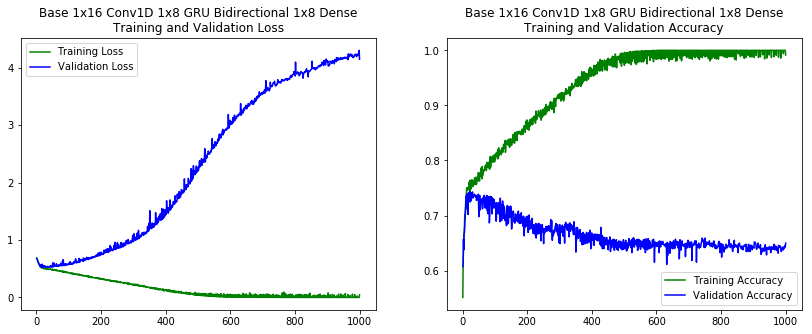

In [43]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['acc']
val_acc = history.history['val_acc']
epochs = range(1, len(train_loss) + 1)
plt.figure(figsize=(14, 5))
plt.subplot(121)
plt.plot(epochs, train_loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Base 1x16 Conv1D 1x8 GRU Bidirectional 1x8 Dense\nTraining and Validation Loss')
plt.legend()
plt.subplot(122)
plt.plot(epochs, train_acc, 'g', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Base 1x16 Conv1D 1x8 GRU Bidirectional 1x8 Dense\nTraining and Validation Accuracy')
plt.legend()
plt.show()

In [44]:
print('validation loss = {:6.2f} at epoch = {:4d}'.format(min(val_loss), val_loss.index(min(val_loss))))
print('validation accuracy = {:6.2f}% at epoch = {:4d}'.format(max(val_acc) * 100, val_acc.index(max(val_acc))))

validation loss =   0.53 at epoch =   34
validation accuracy =  74.39% at epoch =   21


### 1x16 Conv1D, 1x8 GRU Bi-directional, 1x8 Dense with Dropouts (.6/.6/.6)

In [30]:
from numpy.random import seed
seed(123)
from tensorflow import set_random_seed
set_random_seed(456)

In [31]:
model = Sequential()
model.add(layers.Conv1D(16, 9, activation='relu', input_shape=(200, X_train.shape[-1])))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling1D(2))
model.add(layers.Bidirectional(layers.GRU(8, recurrent_activation='sigmoid',
                                          dropout=0.6, recurrent_dropout=0.6,
                                          reset_after=True)))
model.add(layers.Dropout(0.6))
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dropout(0.6))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer=RMSprop(), loss='binary_crossentropy', metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 192, 16)           1456      
_________________________________________________________________
batch_normalization_1 (Batch (None, 192, 16)           64        
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 96, 16)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 16)                1248      
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 136       
_________________________________________________________________
dropout_2 (Dropout)          (None, 8)                 0         
__________

In [32]:
callbacks_list = [
    ModelCheckpoint(
        filepath='pcp-1x16cv-1x8gruB-1x8d-dropout060606.best.h5',
        monitor='val_loss',
        save_best_only=True
    ),
    TensorBoard(
        log_dir='tsb_log'
    )
]

In [33]:
train_to_epoch = 1000
start_epoch = 0
t1 = datetime.datetime.now()
print('Training start time = %s' %  t1)
history = model.fit(X_train, y_train,
                    batch_size=128,  epochs=train_to_epoch, verbose=0,
                    callbacks=callbacks_list, initial_epoch=start_epoch,
                    validation_data=(X_val, y_val), shuffle=True)
print('\nTraining Duration = %s' % (datetime.datetime.now()-t1))

Training start time = 2019-03-24 14:13:06.996230

Training Duration = 0:39:38.929852


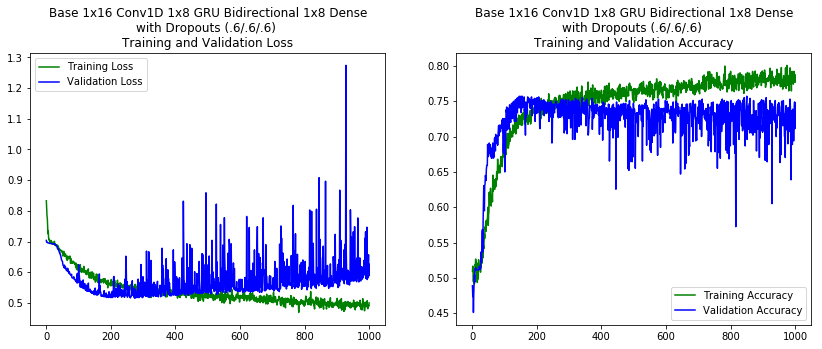

In [34]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['acc']
val_acc = history.history['val_acc']
epochs = range(1, len(train_loss) + 1)
plt.figure(figsize=(14, 5))
plt.subplot(121)
plt.plot(epochs, train_loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Base 1x16 Conv1D 1x8 GRU Bidirectional 1x8 Dense\nwith Dropouts (.6/.6/.6) \nTraining and Validation Loss')
plt.legend()
plt.subplot(122)
plt.plot(epochs, train_acc, 'g', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Base 1x16 Conv1D 1x8 GRU Bidirectional 1x8 Dense\nwith Dropouts (.6/.6/.6) \nTraining and Validation Accuracy')
plt.legend()
plt.show()

In [35]:
print('validation loss = {:6.2f} at epoch = {:4d}'.format(min(val_loss), val_loss.index(min(val_loss))))
print('validation accuracy = {:6.2f}% at epoch = {:4d}'.format(max(val_acc) * 100, val_acc.index(max(val_acc))))

validation loss =   0.52 at epoch =  274
validation accuracy =  75.71% at epoch =  145


### 1x16 Conv1D, 2x8 GRU Bi-directional, 1x8 Dense with Dropouts (.6/.6/.6)

In [30]:
from numpy.random import seed
seed(123)
from tensorflow import set_random_seed
set_random_seed(456)

In [31]:
model = Sequential()
model.add(layers.Conv1D(16, 9, activation='relu', input_shape=(200, X_train.shape[-1])))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling1D(2))
model.add(layers.Bidirectional(layers.GRU(8, recurrent_activation='sigmoid',
                                          dropout=0.6, recurrent_dropout=0.6,
                                          reset_after=True, return_sequences=True)))
model.add(layers.Bidirectional(layers.GRU(8, recurrent_activation='sigmoid',
                                          dropout=0.6, recurrent_dropout=0.6,
                                          reset_after=True)))
model.add(layers.Dropout(0.6))
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dropout(0.6))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer=RMSprop(), loss='binary_crossentropy', metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 192, 16)           1456      
_________________________________________________________________
batch_normalization_1 (Batch (None, 192, 16)           64        
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 96, 16)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 96, 16)            1248      
_________________________________________________________________
bidirectional_2 (Bidirection (None, 16)                1248      
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 136       
__________

In [36]:
callbacks_list = [
    ModelCheckpoint(
        filepath='pcp-1x16cv-2x8gruB-1x8d-dropout060606-epchxxx.best.h5',
        monitor='val_loss',
        save_best_only=True
    ),
    TensorBoard(
        log_dir='tsb_log',
        histogram_freq=1,
        batch_size=128,
        write_graph=True, write_grads=True, write_images=True
    )
]

In [41]:
histories = []

In [37]:
train_to_epoch = 1200
start_epoch = 1000
t1 = datetime.datetime.now()
print('Training start time = %s' %  t1)
history = model.fit(X_train, y_train,
                    batch_size=128,  epochs=train_to_epoch, verbose=0,
                    callbacks=callbacks_list, initial_epoch=start_epoch,
                    validation_data=(X_val, y_val), shuffle=True)
print('\nTraining Duration = %s' % (datetime.datetime.now()-t1))
histories.append(history.history)

Training start time = 2019-03-24 16:31:14.765600

Training Duration = 0:47:15.903108


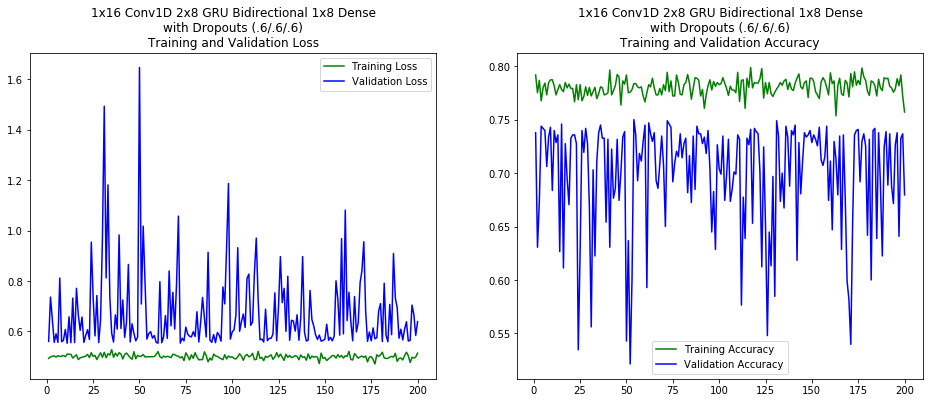

In [44]:
train_loss = []
val_loss = []
train_acc = []
val_acc = []
for h in histories:
    for a_loss in h['loss']:
        train_loss.append(a_loss)
    for a_loss in h['val_loss']:
        val_loss.append(a_loss)
    for a_acc in h['acc']:
        train_acc.append(a_acc)
    for a_acc in h['val_acc']:
        val_acc.append(a_acc)
epochs = range(1, len(train_loss) + 1)
plt.figure(figsize=(16, 6))
plt.subplot(121)
plt.plot(epochs, train_loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('1x16 Conv1D 2x8 GRU Bidirectional 1x8 Dense\nwith Dropouts (.6/.6/.6)\nTraining and Validation Loss')
plt.legend()
plt.subplot(122)
plt.plot(epochs, train_acc, 'g', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('1x16 Conv1D 2x8 GRU Bidirectional 1x8 Dense\nwith Dropouts (.6/.6/.6)\nTraining and Validation Accuracy')
plt.legend()
plt.show()

In [ ]:
print('validation loss = {:6.2f} at epoch = {:4d}'.format(min(val_loss), val_loss.index(min(val_loss))))
print('validation accuracy = {:6.2f}% at epoch = {:4d}'.format(max(val_acc) * 100, val_acc.index(max(val_acc))))

after 1200 epochs
* validation loss =   0.52 at epoch =  359
* validation accuracy =  75.82% at epoch =  641

# ============= Work in Progress ===============

### 1x16 Conv1D, 3x8 GRU Bi-directional, 1x8 Dense with Dropouts (.6/.6/.6)

In [30]:
from numpy.random import seed
seed(123)
from tensorflow import set_random_seed
set_random_seed(456)

In [31]:
model = Sequential()
model.add(layers.Conv1D(16, 9, activation='relu', input_shape=(200, X_train.shape[-1])))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling1D(2))
model.add(layers.Bidirectional(layers.GRU(8, recurrent_activation='sigmoid',
                                          dropout=0.6, recurrent_dropout=0.6,
                                          reset_after=True, return_sequences=True)))
model.add(layers.Bidirectional(layers.GRU(8, recurrent_activation='sigmoid',
                                          dropout=0.3, recurrent_dropout=0.3,
                                          reset_after=True, return_sequences=True)))
model.add(layers.Bidirectional(layers.GRU(8, recurrent_activation='sigmoid',
                                          dropout=0.1, recurrent_dropout=0.1,
                                          reset_after=True)))
model.add(layers.Dropout(0.6))
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dropout(0.6))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer=RMSprop(), loss='binary_crossentropy', metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 192, 16)           1456      
_________________________________________________________________
batch_normalization_1 (Batch (None, 192, 16)           64        
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 96, 16)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 96, 16)            1248      
_________________________________________________________________
bidirectional_2 (Bidirection (None, 96, 16)            1248      
_________________________________________________________________
bidirectional_3 (Bidirection (None, 16)                1248      
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
__________

In [31]:
callbacks_list = [
    ModelCheckpoint(
        filepath='pcp-1x16cv-3x8gruB-1x8d-dropout060606-epchxxx.best.h5',
        monitor='val_loss',
        save_best_only=True
    ),
    TensorBoard(
        log_dir='tsb_log',
        histogram_freq=1,
        batch_size=128,
        write_graph=True, write_grads=True, write_images=True
    )
]

In [33]:
histories = []

In [36]:
# Temporary - to remove after training is completed
# Load previous history
with open(os.path.join('models', 'pcp-1x16cv-3x8gruB-1x8d-dropout060606-histories-epch500.pkl'), 'rb') as infile:
    histories = pickle.load(infile)
# Load previous model
model = load_model(os.path.join('models', 'pcp-1x16cv-3x8gruB-1x8d-dropout060606-epch500.h5'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 192, 16)           1456      
_________________________________________________________________
batch_normalization_1 (Batch (None, 192, 16)           64        
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 96, 16)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 96, 16)            1248      
_________________________________________________________________
bidirectional_2 (Bidirection (None, 96, 16)            1248      
_________________________________________________________________
bidirectional_3 (Bidirection (None, 16)                1248      
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
__________

In [52]:
train_to_epoch = 1400
start_epoch = 1200
t1 = datetime.datetime.now()
print('Training start time = %s' %  t1)
history = model.fit(X_train, y_train,
                    batch_size=128,  epochs=train_to_epoch, verbose=0,
                    callbacks=callbacks_list, initial_epoch=start_epoch,
                    validation_data=(X_val, y_val), shuffle=True)
print('\nTraining Duration = %s' % (datetime.datetime.now()-t1))
histories.append(history.history)

Training start time = 2019-03-30 22:52:02.372805

Training Duration = 1:17:41.099677


In [53]:
with open(os.path.join('pcp-1x16cv-3x8gruB-1x8d-dropout060606-histories-epch' + str(train_to_epoch) + '.pkl'),
          'wb') as outfile:
    pickle.dump(histories, outfile)

In [54]:
model.save(os.path.join('pcp-1x16cv-3x8gruB-1x8d-dropout060606-epch' + str(train_to_epoch) + '.h5'))

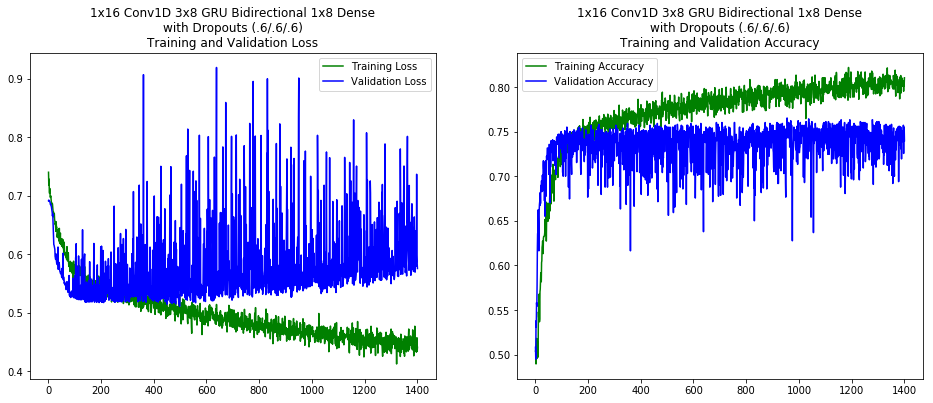

In [55]:
train_loss = []
val_loss = []
train_acc = []
val_acc = []
for h in histories:
    for a_loss in h['loss']:
        train_loss.append(a_loss)
    for a_loss in h['val_loss']:
        val_loss.append(a_loss)
    for a_acc in h['acc']:
        train_acc.append(a_acc)
    for a_acc in h['val_acc']:
        val_acc.append(a_acc)
epochs = range(1, len(train_loss) + 1)
plt.figure(figsize=(16, 6))
plt.subplot(121)
plt.plot(epochs, train_loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('1x16 Conv1D 3x8 GRU Bidirectional 1x8 Dense\nwith Dropouts (.6/.6/.6)\nTraining and Validation Loss')
plt.legend()
plt.subplot(122)
plt.plot(epochs, train_acc, 'g', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('1x16 Conv1D 3x8 GRU Bidirectional 1x8 Dense\nwith Dropouts (.6/.6/.6)\nTraining and Validation Accuracy')
plt.legend()
plt.show()

In [56]:
print('validation loss = {:6.2f} at epoch = {:4d}'.format(min(val_loss), val_loss.index(min(val_loss))))
print('validation accuracy = {:6.2f}% at epoch = {:4d}'.format(max(val_acc) * 100, val_acc.index(max(val_acc))))

validation loss =   0.51 at epoch =  497
validation accuracy =  76.53% at epoch =  954


after 500 epochs :
* validation loss =   0.51 at epoch =  497
* validation accuracy =  75.92% at epoch =  462

after 700 epochs :
* validation loss =   0.51 at epoch =  497
* validation accuracy =  76.02% at epoch =  686

after 700 epochs :
* validation loss =   0.51 at epoch =  497
* validation accuracy =  76.53% at epoch =  954